In [11]:
#Connecting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE

# Set path to your dataset
data_dir = '/content/drive/MyDrive/chest_xray (1)'

#Resizing image and configuring batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training data
train_ds = image_dataset_from_directory(
    directory=f"{data_dir}/train",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

#Load validation data
val_ds = image_dataset_from_directory(
    directory=f"{data_dir}/val",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load test data
test_ds = image_dataset_from_directory(
    directory=f"{data_dir}/test",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Prefetch batch for optimized performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 6818 files belonging to 2 classes.
Found 1172 files belonging to 2 classes.
Found 586 files belonging to 2 classes.


In [13]:
# Optimize
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def build_mobilenetv2():
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs, outputs)



In [15]:
mobilenetv2 = build_mobilenetv2()
mobilenetv2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

mobilenetv2_history = mobilenetv2.fit(train_ds, validation_data=val_ds, epochs=5)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 134s 564ms/step - accuracy: 0.5137 - loss: 0.7219 - val_accuracy: 0.5913 - val_loss: 0.6690
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 94s 376ms/step - accuracy: 0.5614 - loss: 0.6837 - val_accuracy: 0.5000 - val_loss: 0.6671
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 80s 368ms/step - accuracy: 0.5856 - loss: 0.6687 - val_accuracy: 0.5563 - val_loss: 0.6411
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 91s 409ms/step - accuracy: 0.6224 - loss: 0.6460 - val_accuracy: 0.7176 - val_loss: 0.6196
Epoch 5/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 142s 411ms/step - accuracy: 0.6622 - loss: 0.6334 - val_accuracy: 0.8703 - val_loss: 0.6022


In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get predicted probabilities
y_probs =mobilenetv2.predict(test_ds)
y_pred = (y_probs > 0.5).astype("int").flatten()


19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 377ms/step


In [17]:
# Accuracy
print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))


Accuracy: 87.20%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.87      0.87      0.87       293
   PNEUMONIA       0.87      0.87      0.87       293

    accuracy                           0.87       586
   macro avg       0.87      0.87      0.87       586
weighted avg       0.87      0.87      0.87       586



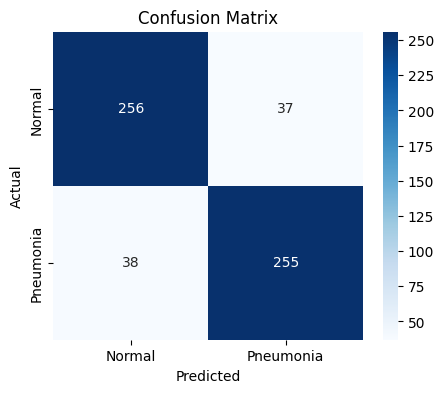

In [18]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [19]:
auc = roc_auc_score(y_true, y_probs)
print(f"AUC Score: {auc:.4f}")


AUC Score: 0.9256


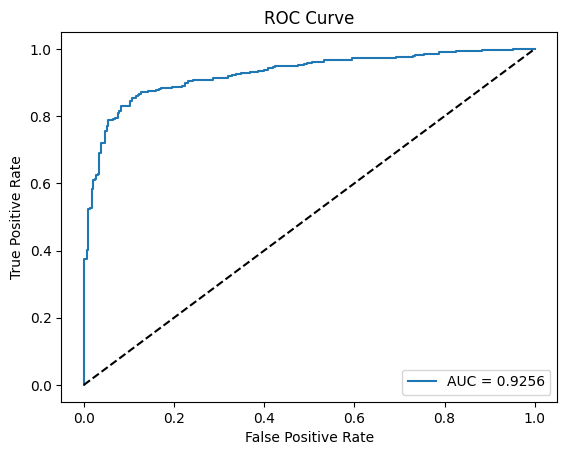

In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
